# Using pre-trained embedding with Tensorflow Hub

**Learning Objectives**
1. How to instantiate a Tensorflow Hub module
1. How to find pretrained Tensorflow Hub module for variety of purposes
1. How to use a pre-trained TF Hub text modules to generate sentence vectors
1. How to incorporate a pre-trained TF-Hub module into a Keras model



## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset.

First, we will load and pre-process the texts and labels so that they are suitable to be fed to sequential Keras models with first layer being TF-hub pre-trained modules. Thanks to this first layer, we won't need to tokenize and integerize the text before passing it to our models. The pre-trained layer will take care of that for us, and consume directly raw text. However, we will still have to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will build, train and compare simple models starting with different pre-trained TF-Hub layers.

In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
!pip install --user google-cloud-bigquery==1.25.0

**Note**: Restart your kernel to use updated packages.

Kindly ignore the deprecation warnings and incompatibility errors related to google-cloud-storage.

In [3]:
import os

from google.cloud import bigquery
import pandas as pd

In [4]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [5]:
PROJECT = "qwiklabs-gcp-03-0ac1fdb352f9"  # Replace with your PROJECT
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION
SEED = 0

## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [6]:
%%bigquery --project $PROJECT

SELECT *
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

,id,by,score,time,time_ts,title,url,text,deleted,dead,descendants,author
0,7982594,mariogintili,11,1404389867,2014-07-03 12:17:47+00:00,"Show HN: Code Cards, Like Texas hold 'em for p...",https://www.kickstarter.com/projects/carlosxcl...,"I found learning to code extremely hard, I stu...",None,True,NaN,mariogintili
1,1892950,story,11,1289451503,2010-11-11 04:58:23+00:00,Best Roommate Ad Ever,http://vancouver.en.craigslist.ca/van/roo/2035...,"eHarmony launches ""roommate compatibility quiz...",None,True,0.0,story
2,7535639,aortega,11,1396662334,2014-04-05 01:45:34+00:00,Deep-Submicron Backdoors,https://github.com/Groundworkstech/Submicron,Repository of resources and documentation to b...,None,None,0.0,aortega
3,3456280,Jamesmagno,11,1326376182,2012-01-12 13:49:42+00:00,Could this be the solution for the 99%?,http://empowerunited.com/,This might actually work AND make a difference.,None,True,0.0,Jamesmagno
4,4477485,hackernew,11,1346809401,2012-09-05 01:43:21+00:00,Braun vs. Apple: Is copying designs theft or i...,http://themanufacturingrevolution.com/braun-vs...,Braun’s biggest victory over Apple underscores...,None,None,1.0,hackernew
5,3738463,ajinkyadot,11,1332392401,2012-03-22 05:00:01+00:00,"GitHub Styleguide - CSS, HTML, JS, Ruby",https://github.com/styleguide/,Welcome to the GitHub styleguide. This is wher...,None,None,1.0,ajinkyadot
6,3611921,mintusingh,11,1329732304,2012-02-20 10:05:04+00:00,Essential Firefox Add-Ons to Make You More Pro...,http://zoomzum.com/10-best-firefox-add-ons-to-...,Firefox can de undoubtedly termed as the best ...,None,True,1.0,mintusingh
7,243057,jjersin,11,1215733888,2008-07-10 23:51:28+00:00,Feedback on our social media iPhone app,http://www.zintin.com,"We, zintin, have just launched our social medi...",None,True,2.0,jjersin
8,3532209,jmalter,11,1327993531,2012-01-31 07:05:31+00:00,Guess Who’s Coming to Dinner…To Save Our Company,http://founderdating.com/comingtodinner/,The true story of how the Get Satisfaction co-...,None,None,2.0,jmalter
9,4128922,amcgregor,11,1340058339,2012-06-18 22:25:39+00:00,Poor Man's Template A/B Testing (in Django),http://tech.matchfwd.com/poor-mans-template-ab...,Ever wanted to A/B test your templates in Djan...,None,None,2.0,amcgregor


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL.

In [7]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 1000

,source,num_articles
0,blogspot,41386
1,github,36525
2,techcrunch,30891
3,youtube,30848
4,nytimes,28787
...,...,...
995,itwire,111
996,allroofingsolutionsde,111
997,codebetter,111
998,betaboston,111


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [10]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



blogspot       41386
github         36525
techcrunch     30891
youtube        30848
nytimes        28787
medium         18422
google         18235
wordpress      17667
arstechnica    13749
wired          12841

For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [11]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

,title,source
0,this guy just found out how to bypass adblocker,github
1,show hn dodo command line task management f...,github
2,without coding test test automation for javas...,github
3,clojure s first code commit authored 8 years ...,github
4,hikaricp a solid high-performance jdbc connect...,github


In [12]:
title_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96203 entries, 0 to 96202
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   96203 non-null  object
 1   source  96203 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [13]:
title_dataset.describe().transpose()

,count,unique,top,freq
title,96203,92395,github is down,31
source,96203,3,github,36525


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last column to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [14]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 96203 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [15]:
title_dataset.source.value_counts()

github        36525
techcrunch    30891
nytimes       28787
Name: source, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [17]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [18]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

#title_dataset.to_csv(
#    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

In [19]:
sample_title_dataset = title_dataset.sample(n=1000)
sample_title_dataset.source.value_counts()

github        369
techcrunch    320
nytimes       311
Name: source, dtype: int64

Let's write the sample datatset to disk.

In [20]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [21]:
sample_title_dataset.head()

,title,source
84947,samsung s iron man galaxy s6 edge is coming ...,techcrunch
38175,the sun is the best optometrist,nytimes
89980,askmarkets launches prediction market for crun...,techcrunch
7453,bigfoot - scalable web framework made of vapour,github
67545,rockyou raises a whopper $50 million in vent...,techcrunch


In [22]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2.3.1


In [23]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [24]:
MODEL_DIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

As in the previous labs, our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times):

In [25]:
ls ./data/

titles_full.csv  titles_sample.csv


In [26]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,sv computer history museum overhauled,nytimes
1,speedtrack sues just about every major online ...,techcrunch
2,show hn shortcut system-wide hot key api,github
3,a ruby interface to yammer s rest api,github
4,live photo stream from sochi olympics using p...,nytimes


Let's look again at the number of examples per label to make sure we have a well-balanced dataset:

In [27]:
titles_df.source.value_counts()

github        36525
techcrunch    30891
nytimes       28787
Name: source, dtype: int64

## Preparing the labels

In this lab, we will use pre-trained [TF-Hub embeddings modules for english](https://tfhub.dev/s?q=tf2%20embeddings%20text%20english) for the first layer of our models. One immediate
advantage of doing so is that the TF-Hub embedding module will take care for us of processing the raw text. 
This also means that our model will be able to consume text directly instead of sequences of integers representing the words.

However, as before, we still need to preprocess the labels into one-hot-encoded vectors:

In [28]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [29]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [30]:
encode_labels(titles_df.source[:4])

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [31]:
N_TRAIN = int(len(titles_df) * 0.95)
print(N_TRAIN)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

91392


To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per class.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.

In [32]:
sources_train.value_counts()

github        34748
techcrunch    29337
nytimes       27307
Name: source, dtype: int64

In [33]:
sources_valid.value_counts()

github        1777
techcrunch    1554
nytimes       1480
Name: source, dtype: int64

In [35]:
titles_train[:10].values

array(['sv computer history museum overhauled',
       'speedtrack sues just about every major online retailer over patent infringement',
       'show hn  shortcut   system-wide hot key api',
       'a ruby interface to yammer s rest api',
       'live photo stream from sochi olympics  using pusher.js ',
       'generate logic gate diagrams automatically',
       'facebook lures advertisers with educational fasttrack and start to success',
       'hipcamp raises $2m to get people camping',
       'the guts of a new machine  2003 ',
       'what a merged sprint and t-mobile would look like'], dtype=object)

Now let's create the features and labels we will feed our models with:

In [36]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [37]:
X_train[:3]

array(['sv computer history museum overhauled',
       'speedtrack sues just about every major online retailer over patent infringement',
       'show hn  shortcut   system-wide hot key api'], dtype=object)

In [38]:
Y_train[:3]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

## NNLM Model

We will first try a word embedding pre-trained using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also
normalizes the vectors produced. 

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [40]:
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(
    NNLM, output_shape=[50], input_shape=[], dtype=tf.string, trainable=True)

Note that this TF-Hub embedding produces a single 50-dimensional vector when passed a sentence:

In [41]:
nnlm_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.19331802,  0.05893906,  0.15330684,  0.2505918 ,  0.19369544,
         0.03578748,  0.07387847, -0.10962156, -0.11377034,  0.07172022,
         0.12458669, -0.02289705, -0.18177685, -0.07084437, -0.00225849,
        -0.36875236,  0.05772953, -0.14222091,  0.08765972, -0.14068899,
        -0.07005888, -0.20634466,  0.07220475,  0.04258814,  0.0955702 ,
         0.19424029, -0.42492998, -0.00706906, -0.02095   , -0.05055764,
        -0.18988201, -0.02841404,  0.13222624, -0.01459922, -0.31255388,
        -0.09577855,  0.05469003, -0.13858607,  0.01141668, -0.12352604,
        -0.07250367, -0.11605677, -0.06976165,  0.14313601, -0.15183711,
        -0.06836402,  0.03054246, -0.13259597, -0.14599673,  0.05094011]],
      dtype=float32)>

## Building the models

Let's write a function that 

* takes as input an instance of a `KerasLayer` (i.e. the `nnlm_module` we constructed above) as well as the name of the model (say `nnlm`)
* returns a compiled Keras sequential model starting with this pre-trained TF-hub layer, adding one or more dense relu layers to it, and ending with a softmax layer giving the probability of each of the classes:

In [63]:
def build_model(hub_module, name):
    model = Sequential([
        hub_module, # TODO 
        Dense(32, activation='relu'),
        Dense(N_CLASSES, activation='softmax')
    ], name=name)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr = 0.0001,beta_1 =0.5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's also wrap the training code into a `train_and_evaluate` function that 
* takes as input the training and validation data, as well as the compiled model itself, and the `batch_size`
* trains the compiled model for 100 epochs at most, and does early-stopping when the validation loss is no longer decreasing
* returns an `history` object, which will help us to plot the learning curves

In [64]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [65]:
def train_and_evaluate(train_data, val_data, model, batch_size=8000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train, Y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[EarlyStopping(),TensorBoard(model_dir)],
    )
    return history

## Training NNLM

In [66]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [67]:
nnlm_model = build_model(nnlm_module, 'nnlm')
nnlm_history = train_and_evaluate(data, val_data, nnlm_model)

Epoch 1/100
12/12 [==============================] - 4s 367ms/step - loss: 1.1248 - accuracy: 0.3543 - val_loss: 1.1088 - val_accuracy: 0.3602
Epoch 2/100
12/12 [==============================] - 4s 340ms/step - loss: 1.0867 - accuracy: 0.3857 - val_loss: 1.0749 - val_accuracy: 0.3920
Epoch 3/100
12/12 [==============================] - 4s 363ms/step - loss: 1.0499 - accuracy: 0.4245 - val_loss: 1.0423 - val_accuracy: 0.4332
Epoch 4/100
12/12 [==============================] - 4s 331ms/step - loss: 1.0145 - accuracy: 0.4722 - val_loss: 1.0110 - val_accuracy: 0.4814
Epoch 5/100
12/12 [==============================] - 4s 350ms/step - loss: 0.9804 - accuracy: 0.5340 - val_loss: 0.9809 - val_accuracy: 0.5492
Epoch 6/100
12/12 [==============================] - 4s 338ms/step - loss: 0.9475 - accuracy: 0.6079 - val_loss: 0.9519 - val_accuracy: 0.6161
Epoch 7/100
12/12 [==============================] - 4s 332ms/step - loss: 0.9157 - accuracy: 0.6786 - val_loss: 0.9239 - val_accuracy: 0.6708

<AxesSubplot:>

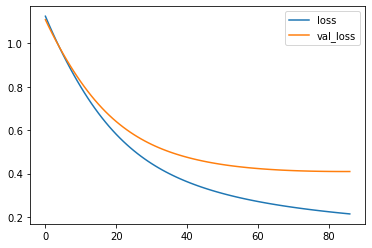

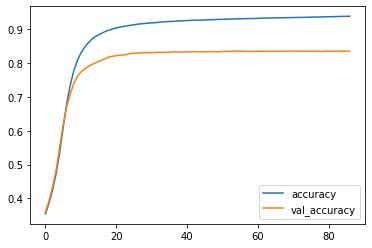

In [68]:
history = nnlm_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

## Bonus

Try to beat the best model by modifying the model architecture, changing the TF-Hub embedding, and tweaking the training parameters.

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License